# Three-Homolog, replicate fits

**Set the visible devices for GPU training**

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
# multidms.model.jax.config.update("jax_enable_x64", True)
# multidms.model.jax.config.update("jax_debug_nans", True)

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [9]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [10]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


## Pre-Proccessing

In [11]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.aa_substitutions.fillna("", inplace=True)
func_score_df.sort_values(by="condition", inplace=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-null   

In [12]:
func_score_df.condition.unique()

array(['Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 'Omicron_BA1-1',
       'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2'],
      dtype=object)

In [13]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "pseudocount" : 0.1,
    "sample" : False,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False
}

**Optionally subset the variants**

In [14]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

In [15]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1
60179,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,GAATGGTATGGCCGCG,0.4364,0.0089,521,428,1154532,701032,0.5,7,L10V G75D Y447N R680W A827S A1018D V1226E,7,L10V G75D Y449N R682W A829S A1020D V1228E,23,Delta,2,Delta-1
60178,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CTGTCTAACGCCTACC,-1.8556,0.0278,521,87,1154532,701032,0.5,5,P25S Y363H A769N S811P,4,P25S Y365H A771N S813P,23,Delta,2,Delta-1
60177,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGGCGTGACTCAATTC,-0.0470,0.0108,521,306,1154532,701032,0.5,1,R679S,1,R681S,23,Delta,2,Delta-1
60176,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGCACCAAAATTACAT,1.2236,0.0068,521,739,1154532,701032,0.5,3,V70N S98G V143I,3,V70N S98G V143I,23,Delta,2,Delta-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930493,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAACCAATACCTA,-0.7129,0.0183,287,187,9244303,9882108,0.5,4,P79S S109T D135T K1035N,4,P82S S112T D138T K1038N,69,Omicron_BA2,1,Omicron_BA2-2
930494,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAGTAGTTTATGC,-0.8500,0.0194,287,170,9244303,9882108,0.5,4,L176P A219T G258H N402D,4,L179P A222T G261H N405D,69,Omicron_BA2,1,Omicron_BA2-2
930495,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATATATGCCCAAAC,-2.3933,0.0428,287,58,9244303,9882108,0.5,2,S24F G410E,2,S27F G413E,69,Omicron_BA2,1,Omicron_BA2-2
930497,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATTAAGTTTGATAA,0.6685,0.0115,287,488,9244303,9882108,0.5,2,A219V S1239I,2,A222V S1242I,69,Omicron_BA2,1,Omicron_BA2-2


**Drop all variants with pre-counts below a threshold.**

In [16]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
if prep_params["min_pre_counts"] == "bernadeta":
    func_score_df = func_score_df[func_score_df['pre_count'] >= func_score_df['pre_count_threshold']]
else:
    func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]

print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


In [17]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**remove all variants with string sites and stop codon wildtypes**

In [18]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

In [19]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

**Optionally, clip the target functional scores**

In [20]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

## Generate Replicate Datasets

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [21]:
datasets = pd.DataFrame()

In [22]:
help(multidms.MultiDmsData)

Help on class MultiDmsData in module multidms.data:

class MultiDmsData(builtins.object)
 |  MultiDmsData(variants_df: pandas.core.frame.DataFrame, reference: str, alphabet=('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'), collapse_identical_variants='mean', condition_colors=('#0072B2', '#CC79A7', '#009E73', '#17BECF', '#BCDB22'), letter_suffixed_sites=False, assert_site_integrity=False, filter_non_shared_subs=True, verbose=False, nb_workers=None)
 |  
 |  Prep data for fitting parameters in as MultiDmsModel Object,
 |  Summarize, and provide static data attributes.
 |  Individual objects of this type can be shared
 |  by multiple ``multidms.MultiDmsModel`` Objects
 |  for effeciently fitting various models to the same data.
 |  
 |  Note
 |  ----
 |  You can initialize a :class:`MultiDmsData` object with a ``pd.DataFrame``
 |  with a row for each variant sampled and annotations
 |  provided in the required columns:
 |  
 |  1. `condi

**Choose the libraries you would like in each of the two replicates**

In [23]:
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

for reference in ["Omicron_BA1"]: # can add 'Delta' if you would like to 
    for rep_fsdf in [fs_rep1, fs_rep2]:       
        
        start = time.time()
        data = multidms.MultiDmsData(
            rep_fsdf,
            collapse_identical_variants=False,
            alphabet= multidms.AAS_WITHSTOP_WITHGAP,
            reference=reference,
            assert_site_integrity = False
        )
        
        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")
        
        prep_params['conditions'] = tuple(rep_fsdf.condition.unique())
        prep_params['time_to_prep'] = prep_time
        prep_params['reference'] = reference
        data_row = pd.Series(prep_params).to_frame().T
        data_row['data'] = data
        datasets = pd.concat([datasets, data_row], ignore_index=True)
    

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 60
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 57


In [24]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040', 
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
# cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
cc = {con:col for con, col in zip(conditions, palette)}


for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [25]:
datasets

,scale_counts,pseudocount,sample,min_pre_counts,clip_target,trim,conditions,time_to_prep,reference,data
0,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1, Omicron_BA2)",60,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f9041...
1,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1, Omicron_BA2)",57,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f8f69...


In [20]:
# datasets.loc[0, "data"].training_data['y']['Delta']

In [4]:
import pickle

In [7]:
models = pickle.load(open("ch-nogamma-models.pkl", "rb"))

In [32]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1523929050798674, 1.0012908512497196, 0.960...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
1,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1656740064523659, 1.026540844040167, 0.9654...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
2,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1566163287107094, 1.00333251223304, 0.95930...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
3,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.167221087644752, 1.0267530729714733, 0.9666...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
4,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1706817197781783, 1.0162400372550007, 0.964...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
5,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1757587696787435, 1.034713610435807, 0.9824...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
6,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.188947310634746, 1.0347343961984174, 0.9819...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
7,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1972755425620993, 1.054004869127971, 1.0004...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
8,<multidms.data.MultiDmsData object at 0x7f9041...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.225486217562079, 1.0748720015427553, 1.0356...",<multidms.model.MultiDmsModel object at 0x7f7d...,0
9,<multidms.data.MultiDmsData object at 0x7f8f69...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.235781175103789, 1.1004061008662849, 1.0385...",<multidms.model.MultiDmsModel object at 0x7f7d...,1


In [26]:
# models = pd.DataFrame()
fit_iter = 0

# for lasso in [1e-07, 1e-06, 1e-05, 2e-05, 5e-05, 0.0001, 0.0005, 0.001]:
for lasso in [5e-05, 0.0001, 0.0005, 0.001]:
    

    for replicate in datasets.index.values:

        new = {
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Softplus",
            'warmup_beta':False,
            'gamma_corrected':False,
            'conditional_c': True,
            'λ_lasso_shift':lasso,
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
#             'λ_ridge_gamma':1e-3,
            'tol':1e-6,
            'save_model_at':[20000],
            'num_training_steps': 20,
            'iterations_per_step':1000
        }
        start_t = time.time()
        model = multidms.utils.fit_wrapper(datasets.loc[replicate, "data"], **new)
        model['replicate'] = replicate
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/10! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(models, open("ch-nogamma-models.pkl", "wb"))

running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f9041f521d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Softplus',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 1.225486217562079, Time: 36 Seconds
training_step 1/20, Loss: 1.0748720015427553, Time: 29 Seconds
training_step 2/20, Loss: 1.035624447654265, Time: 29 Seconds
training_step 3/20, Loss: 1.0053206467721985, Time: 29 Seconds
training_step 4/20, Loss: 0.9917006190801528, Time: 29 Seconds
training_step 5/20, Loss: 0.9820174405399335, Time: 29 Seconds
trai

training_step 0/20, Loss: 1.2494248589783874, Time: 32 Seconds
training_step 1/20, Loss: 1.1145902411627608, Time: 29 Seconds
training_step 2/20, Loss: 1.0819385591843718, Time: 29 Seconds
training_step 3/20, Loss: 1.0671502016381815, Time: 29 Seconds
training_step 4/20, Loss: 1.0609295015674087, Time: 29 Seconds
training_step 5/20, Loss: 1.0581514222233936, Time: 29 Seconds
training_step 6/20, Loss: 1.0564764571696819, Time: 29 Seconds
training_step 7/20, Loss: 1.0556562487419372, Time: 29 Seconds
training_step 8/20, Loss: 1.0556354321363346, Time: 29 Seconds
training_step 9/20, Loss: 1.0563440725492235, Time: 29 Seconds
training_step 10/20, Loss: 1.0579684270611893, Time: 29 Seconds
training_step 11/20, Loss: 1.0594818995515427, Time: 29 Seconds
training_step 12/20, Loss: 1.060986348789239, Time: 29 Seconds
training_step 13/20, Loss: 1.0624958251154062, Time: 29 Seconds
training_step 14/20, Loss: 1.0639960155074226, Time: 29 Seconds
training_step 15/20, Loss: 1.0653266146501281, Time

In [27]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1523929050798674, 1.0012908512497196, 0.960...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
1,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1656740064523659, 1.026540844040167, 0.9654...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
2,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1566163287107094, 1.00333251223304, 0.95930...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
3,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.167221087644752, 1.0267530729714733, 0.9666...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
4,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1706817197781783, 1.0162400372550007, 0.964...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
5,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1757587696787435, 1.034713610435807, 0.9824...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
6,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.188947310634746, 1.0347343961984174, 0.9819...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
7,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1972755425620993, 1.054004869127971, 1.0004...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
8,<multidms.data.MultiDmsData object at 0x7f9041...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.225486217562079, 1.0748720015427553, 1.0356...",<multidms.model.MultiDmsModel object at 0x7f7d...,0
9,<multidms.data.MultiDmsData object at 0x7f8f69...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.235781175103789, 1.1004061008662849, 1.0385...",<multidms.model.MultiDmsModel object at 0x7f7d...,1


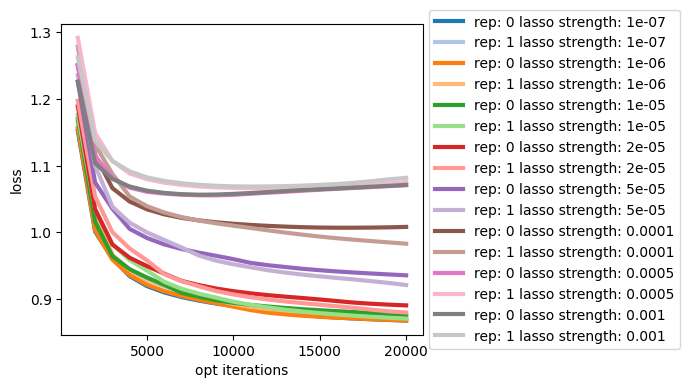

In [28]:
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[7,4])
for i, (model, model_row) in enumerate(models.iterrows()):
    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[i],
        lw=3,
        label=f"rep: {model_row.replicate} lasso strength: {model_row.λ_lasso_shift}"
    )

ax.set_ylabel("loss")
ax.set_xlabel("opt iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [29]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1523929050798674, 1.0012908512497196, 0.960...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
1,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1656740064523659, 1.026540844040167, 0.9654...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
2,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1566163287107094, 1.00333251223304, 0.95930...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
3,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.167221087644752, 1.0267530729714733, 0.9666...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
4,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1706817197781783, 1.0162400372550007, 0.964...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
5,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1757587696787435, 1.034713610435807, 0.9824...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
6,<multidms.data.MultiDmsData object at 0x7f8f64...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.188947310634746, 1.0347343961984174, 0.9819...",<multidms.model.MultiDmsModel object at 0x7f8e...,0
7,<multidms.data.MultiDmsData object at 0x7f8f48...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.1972755425620993, 1.054004869127971, 1.0004...",<multidms.model.MultiDmsModel object at 0x7f8e...,1
8,<multidms.data.MultiDmsData object at 0x7f9041...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.225486217562079, 1.0748720015427553, 1.0356...",<multidms.model.MultiDmsModel object at 0x7f7d...,0
9,<multidms.data.MultiDmsData object at 0x7f8f69...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.235781175103789, 1.1004061008662849, 1.0385...",<multidms.model.MultiDmsModel object at 0x7f7d...,1


In [30]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

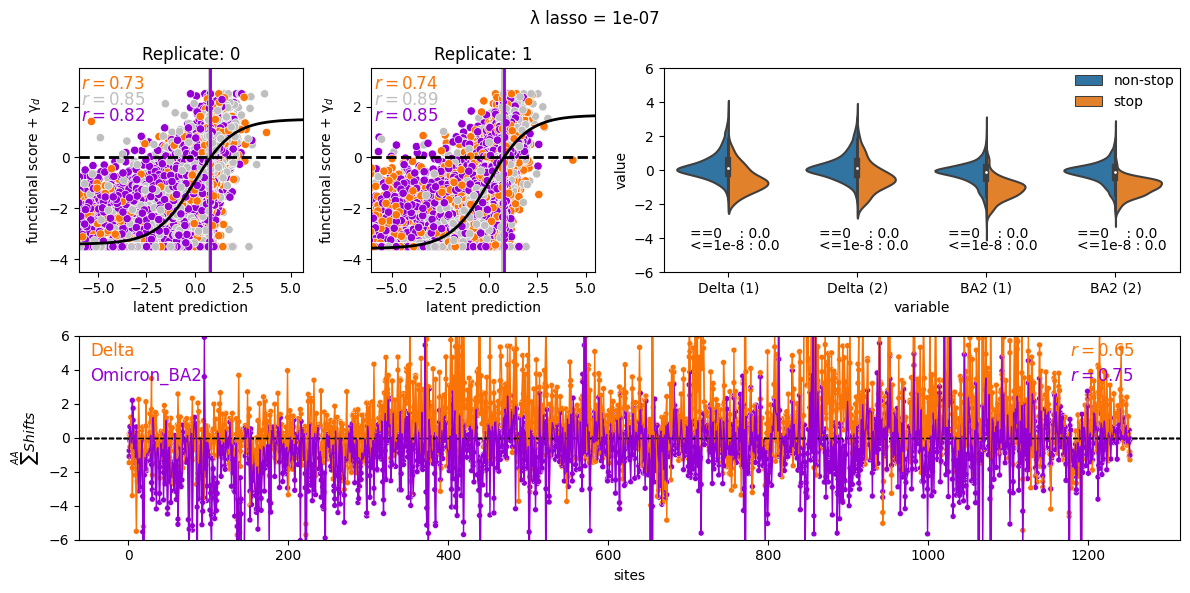

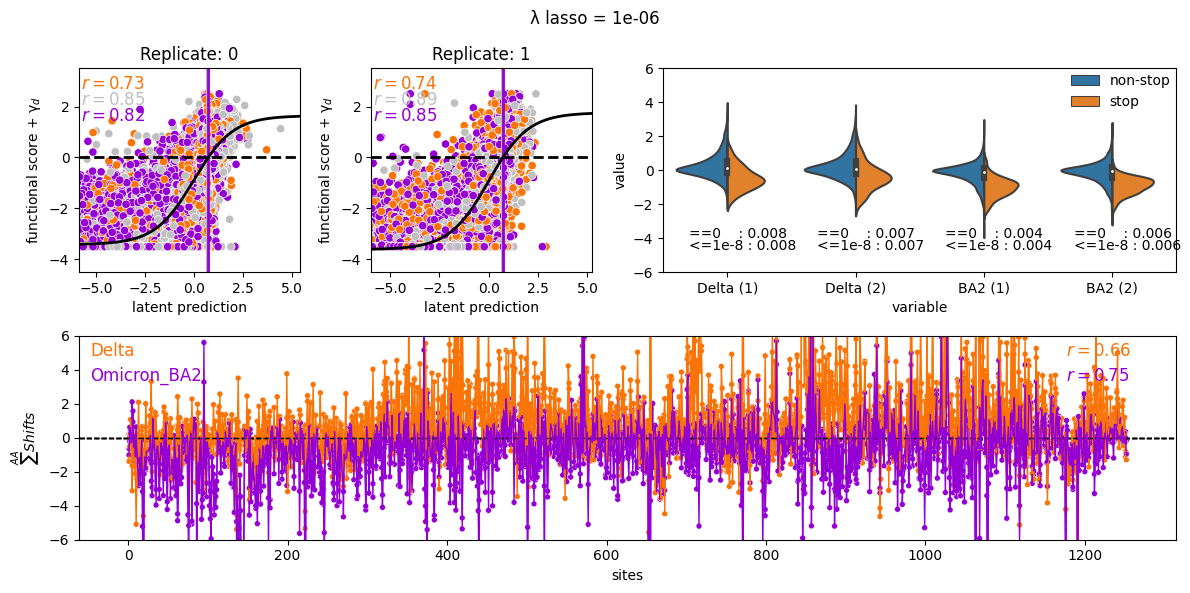

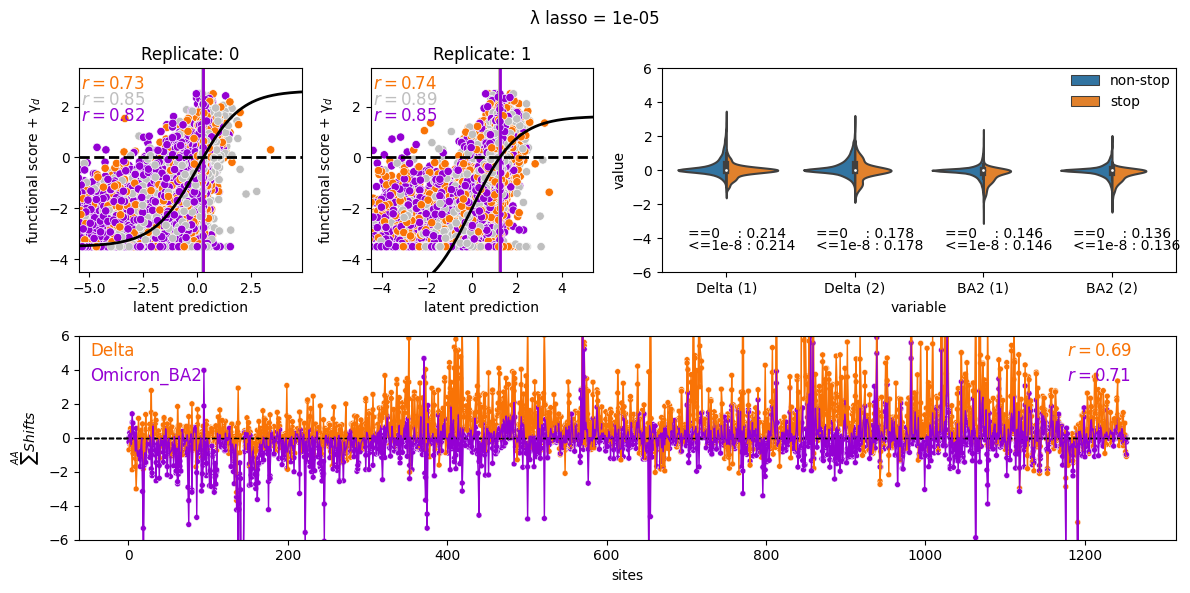

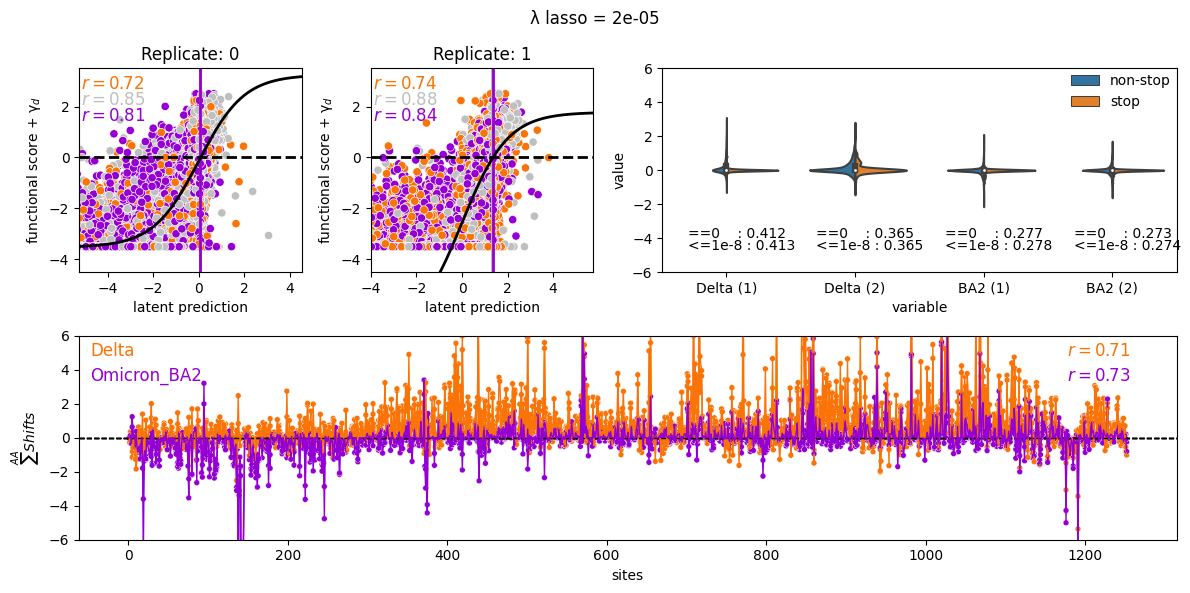

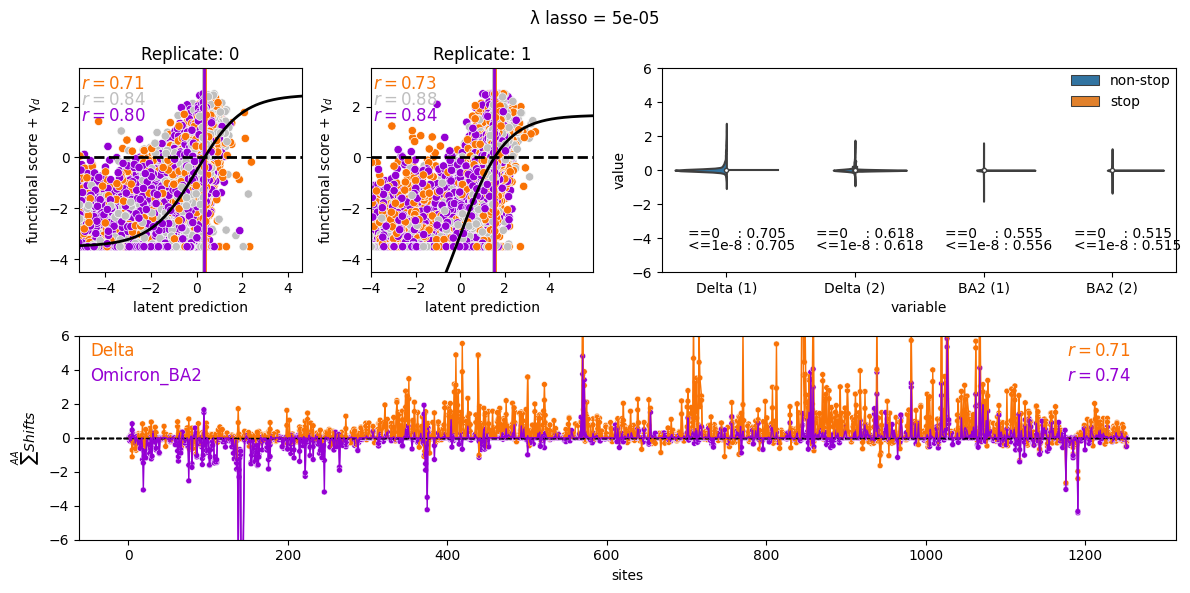

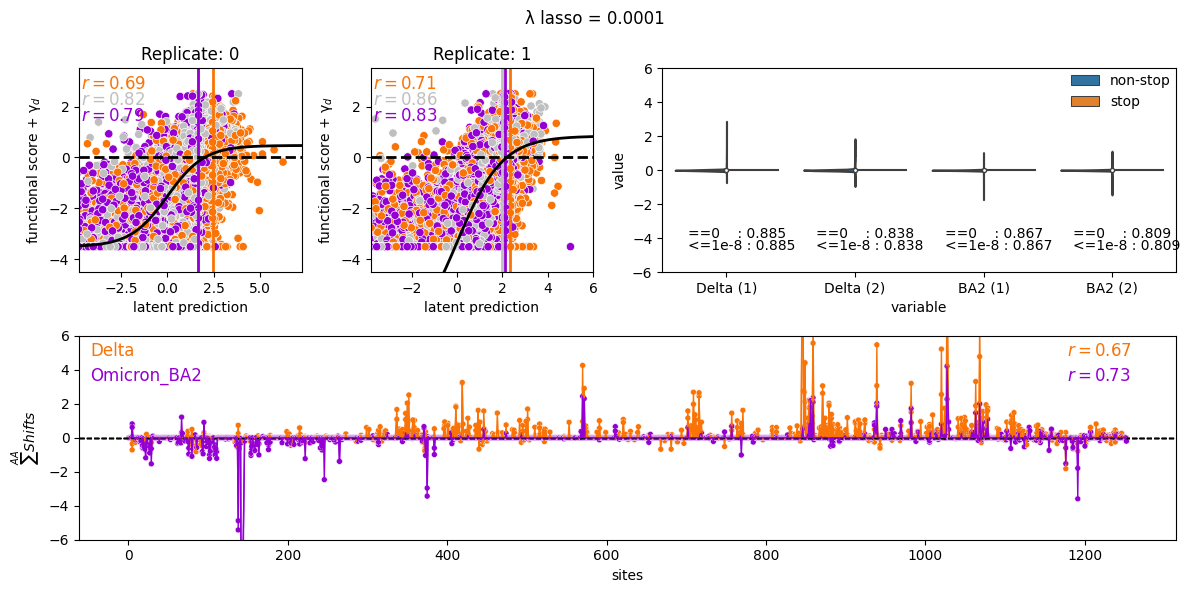

/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


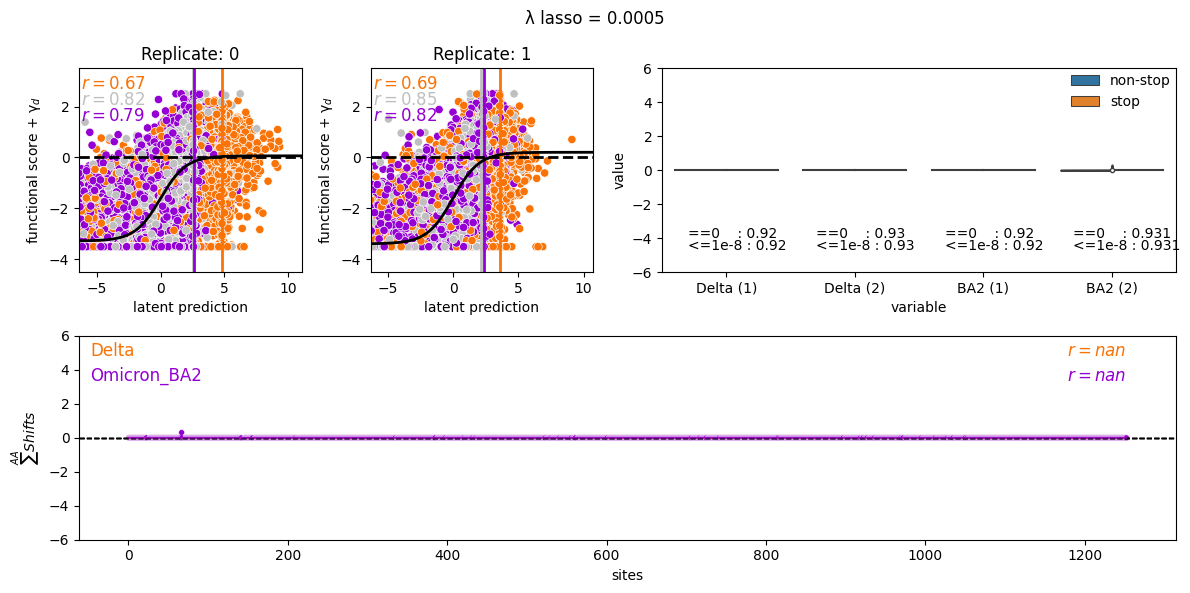

/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


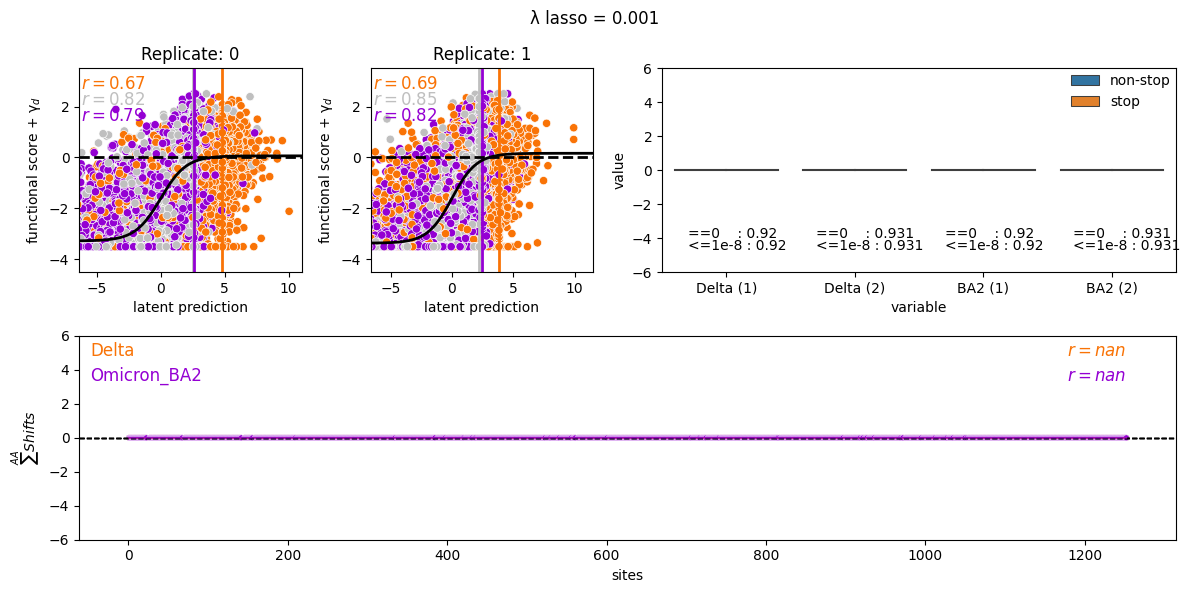

In [31]:
for i, (lasso, lasso_replicates) in enumerate(models.groupby("λ_lasso_shift")):
#     if lasso != 2e-5: continue
    i=0
    fig, ax = plt.subplot_mosaic(
        """
        01DD
        SSSS
        """,
        figsize=[12,6]
    )
    ax[f"S"].set_ylim([-6, 6])
    ax[f"D"].set_ylim([-6, 6])
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row.model_20000
        fit_dict[f"{replicate}"] = model
        
        # epistasis and accuracy
        model.plot_epistasis(show=False, ax=ax[str(replicate)], sample=0.1, legend=False)
        ax[str(replicate)].set_xlabel("latent prediction")
        ax[str(replicate)].set_title(f"Replicate: {replicate}")
        var_df = model.variants_df
        
        for b, cond in enumerate(model.data.conditions):
            var_df_cond = var_df.query(f"condition == @cond")
            corr = pearsonr(
                var_df_cond["predicted_func_score"], 
                var_df_cond["corrected_func_score"] 
            )[0]
            ax[str(replicate)].annotate(
                f"$r = {corr:.2f}$", 
                (0.01, (0.90 - (b*0.08))), 
                xycoords="axes fraction", 
                fontsize=12,
                c = model.data.condition_colors[cond]
            )
            
            if cond == model.data.reference: continue
            model.plot_shifts_by_site(
                cond, 
                show=False, 
                agg_func=onp.sum, 
                times_seen_threshold=3, 
                ax=ax[f"S"], 
                lw=1
            )
    muts_df_outer = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="outer")
    muts_df_inner = muts_df_outer.dropna()
    for b, cond in enumerate(model.data.conditions):
        if cond == model.data.reference: continue 
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])[0]
        ax[f"S"].annotate(
            f"$r = {corr:.2f}$", 
            (0.9, (0.9 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
        ax[f"S"].annotate(
            cond, 
            (0.01, (0.90 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
    ax[f"S"].set_ylabel("$\sum^{AA} Shifts$")
    muts_df_outer = muts_df_outer[
        [c for c in muts_df_outer.columns if "S_" in c and "avg" not in c]
    ]
    muts_df_outer.rename(
        {
            "0_S_Omicron_BA2":"BA2 (1)", 
            "1_S_Omicron_BA2":"BA2 (2)",
            "0_S_Delta":"Delta (1)",
            "1_S_Delta":"Delta (2)"
        },
        axis=1,
        inplace=True
    )
    muts_df_outer = muts_df_outer.assign(
        is_stop=[
            "stop" if "*" in m else "non-stop" 
            for m in muts_df_outer.index.values
        ]
    )
    melted_mut_df = pd.melt(muts_df_outer.reset_index(), id_vars=["mutation", "is_stop"])
    sns.violinplot(
        melted_mut_df, 
        x="variable", 
        y="value", 
        hue="is_stop", 
        ax = ax[f"D"],
        split=True
    )

    ax[f"D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)

        
    for os, (cond, cond_df) in enumerate(melted_mut_df.groupby("variable")):
        exact_sparsity = len(cond_df[cond_df['value'] == 0]) / len(cond_df)
        close_sparsity = len(cond_df[onp.isclose(cond_df['value'], 0)]) / len(cond_df)
        
        ax[f"D"].annotate(f"==0    : {round(exact_sparsity, 3)}", (os-0.3, -4))
        ax[f"D"].annotate(f"<=1e-8 : {round(close_sparsity, 3)}", (os-0.3, -4.7))
        
    
    ax["D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)
    
    fig.suptitle(f"λ lasso = {lasso}")
    plt.tight_layout()
    fig.savefig(f"ch-nogamma-summary-{lasso}.pdf")
    plt.show()

In [112]:
x = onp.random.randint(0, 2, 10)
x[x==0]

array([0, 0, 0, 0, 0, 0])

In [ ]:
model = 

In [ ]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 17})

#         aceX
for model in [0]:
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    axd = fig.subplot_mosaic(
        """
        bbbg
        dddh
        fffi
        """,
        empty_sentinel="X",
        gridspec_kw={ 
        }
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }
    
    moi = models_df.loc[model, "model"]

    facet_groups = {
        ("b", "g") : ("Delta-2", "Delta-3"),
        ("d", "h") : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        ("f", "i") : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi[0]].add_patch(rect_v)
        for r, condition in enumerate(facet_group):
            
            if condition == moi.data.reference: continue
            lw=3.25 if r == 0 else 1.75
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi[0]],
                lw=lw

            )
        axd[axi[0]].set_ylabel("")
        
        if moi.data.reference not in facet_group:          
            from scipy.stats import pearsonr
            
            mut_df = moi.mutation_site_summary_df(agg_func=onp.sum, times_seen_threshold=3)
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="blue"
                
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.82),
                xycoords="axes fraction", fontsize=15, color="black"
            )
            
#             legend_elements = [
# #                 patches.Patch(
# #                      facecolor="black", 
# #                      edgecolor="black", 
# #                      label="all muts"
# #                 ),
#                 patches.Patch(
#                     facecolor="blue", 
#                     edgecolor="black", 
#                     label="$\sum$" #_{m \in site}s_{m,d}$"
#                 )
                
#             ]
#             axd[axi[1]].legend(
#                     handles=legend_elements, 
#                     loc="lower right",
#                     frameon=False,
#                     fontsize=12
#             )
            
#             mut_df = moi.mutations_df
            
#             times_seen_cols = [c for c in mut_df.columns if "times" in c]
#             for c in times_seen_cols:
#                 mut_df = mut_df[mut_df[c]>=3]
                
#             x = mut_df[f"S_{facet_group[0]}"].values
#             y = mut_df[f"S_{facet_group[1]}"].values
#             r = pearsonr(x, y)[0]
#             sns.scatterplot(mut_df,
#                 x=f"S_{facet_group[0]}",
#                 y=f"S_{facet_group[1]}", 
#                 ax=axd[axi[1]],
#                 alpha=0.5,
#                 color="black"
#             )
#             axd[axi[1]].annotate(
#                 f"$r = {r:.2f}$", (0.1, 0.9),
#                 xycoords="axes fraction", fontsize=12, color="black"
#             )
            axd[axi[1]].get_xaxis().set_visible(False)
            axd[axi[1]].get_yaxis().set_visible(False)
            
        
                 
        else:
            
            axd[axi[1]].axis('off')
            
#             conditions = sorted(moi.data.conditions)
#             cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
            legend_elements = [
                patches.Patch(
                     facecolor=col, 
                     edgecolor="black", 
                     label=con
                )
                for con, col in cc.items()
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="center",
                    frameon=False
            )
            
    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}" #": \n{start}-{end}"
        ycoord = 26
        if pr in ["ACE2", "S2'"]:
            ycoord = 16
        if pr in ["FP"]:
            ycoord = 29

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=12, rotation=0)

    axd["b"].get_xaxis().set_visible(False)
    axd["d"].get_xaxis().set_visible(False)
    

#     fig.text(0.00, 0.5, "$\sum_{m \in site}s_{m,d}$", va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f"shifts_reference_{moi.data.reference}.png")

In [ ]:
# fig, ax = 
# for lasso, replicates in models.groupby("λ_lasso_shift"):
#     fig, ax = 

In [ ]:
fit_dict = {
    "rep1" : models.loc[0, "model_20000"],
    "rep2" : models.loc[1, "model_20000"]
}
multidms.plot.mut_shift_plot(fit_dict, include_beta=False)

In [ ]:
fit_dict = {
    "rep1" : models.loc[2, "model_20000"],
    "rep2" : models.loc[3, "model_20000"]
}
multidms.plot.mut_shift_plot(fit_dict, include_beta=False)

In [ ]:
fit_dict = {
    "rep1" : models.loc[4, "model_20000"],
    "rep2" : models.loc[5, "model_20000"]
}
multidms.plot.mut_shift_plot(fit_dict, include_beta=False)